# Toxic Spans Detection

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DougTrajano/olid-br/blob/master/notebooks/baselines/toxic_spans_detection.ipynb)

In this notebook, we will train a model that detects toxic spans in toxic comments. The results can be used to highligh which parts of a given comment are toxic.

This task was first proposed in [SemEval 2021 Task 5: Toxic Spans Detection - CodaLab Competition](https://competitions.codalab.org/competitions/25623).

## Imports

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [3]:
import ast
import csv
import itertools
import os
import random
import string
import sys
import warnings

import numpy as np
import pandas as pd
from typing import List

import spacy
from spacy import displacy
from spacy.tokens import Doc
from spacy.training.example import Example
from sklearn.base import BaseEstimator
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    style="white",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False
    }
)

SPECIAL_CHARACTERS = string.whitespace

In [20]:
from src.kaggle import download_dataset

params = {
    "seed": 1993,
    "num_train_epochs": 30,
    "dropout_rate": 0.1
}

# Set seeds for reproducibility
random.seed(params["seed"])
np.random.seed(params["seed"])
tf.random.set_seed(params["seed"])
spacy.util.fix_random_seed(params["seed"])

In [5]:
def precision_score(y_true: List[int], y_pred: List[int]):
    """
    Compute the precision score operating on two lists of offsets (e.g., character).
    >>> assert precision_score([[0, 1, 4, 5]], [[0, 1, 6]]) == 0.6666666666666666

    Args:
    - y_true: a list of offsets serving as the ground truth
    - y_pred: a list of predicted offsets

    Returns:
    - precision: the precision score
    """   
    scores = []
    for pred, true in zip(y_pred, y_true):
        if len(true) == 0 and len(pred) == 0:
            scores.append(1)
        elif len(true) == 0 and len(pred) != 0:
            scores.append(0)
        elif len(true) != 0 and len(pred) == 0:
            scores.append(0)
        else:
            pred_set = set(pred)
            true_set = set(true)
            scores.append(len(pred_set.intersection(true_set)) / len(pred_set))
            
    return np.mean(scores)

def recall_score(y_true: List[int], y_pred: List[int]):
    """
    Compute the recall score operating on two lists of offsets (e.g., character).
    >>> assert recall_score([[0, 1, 4, 5]], [[0, 1, 6]]) == 0.5

    Args:
    - y_true: a list of offsets serving as the ground truth
    - y_pred: a list of predicted offsets

    Returns:
    - recall: the recall score
    """
    scores = []
    for pred, true in zip(y_pred, y_true):
        if len(true) == 0 and len(pred) == 0:
            scores.append(1)
        elif len(true) == 0 and len(pred) != 0:
            scores.append(0)
        elif len(true) != 0 and len(pred) == 0:
            scores.append(0)
        else:
            pred_set = set(pred)
            true_set = set(true)
            scores.append(len(pred_set.intersection(true_set)) / len(true_set))
    return np.mean(scores)

def f1_score(y_true: List[int], y_pred: List[int]):
    """
    Compute the F1 score operating on two lists of offsets (e.g., character).
    >>> assert f1_score([[0, 1, 4, 5]], [[0, 1, 6]]) == 0.5714285714285715

    Args:
    - y_true: a list of offsets serving as the ground truth
    - y_pred: a list of predicted offsets

    Returns:
    - f1: the F1 score
    """
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if precision + recall == 0:
        return 0.
    return 2 * (precision * recall) / (precision + recall)

assert precision_score([[0, 1, 4, 5]], [[0, 1, 6]]) == 0.6666666666666666
assert recall_score([[0, 1, 4, 5]], [[0, 1, 6]]) == 0.5
assert f1_score([[0, 1, 4, 5]], [[0, 1, 6]]) == 0.5714285714285715

In [6]:
def _contiguous_ranges(span_list: List[int]):
    """Extracts continguous runs [1, 2, 3, 5, 6, 7] -> [(1,3), (5,7)].
    
    Args:
    - span_list: a list of span indicies

    Returns:
    - A list of tuples containing the start and end of each continguous run.
    """
    output = []
    for _, span in itertools.groupby(
        enumerate(span_list), lambda p: p[1] - p[0]):
        span = list(span)
        output.append((span[0][1], span[-1][1]))
    return output

def fix_spans(spans: List[int], text: str, special_characters: str = SPECIAL_CHARACTERS):
    """Applies minor edits to trim spans and remove singletons.
    
    Args:
    - spans: a list of span indicies
    - text: the text to which the spans apply
    - special_characters: a string containing special characters to remove from the text

    Returns:
    - A list of fixed spans.
    """
    cleaned = []
    for begin, end in _contiguous_ranges(spans):
        while text[begin] in special_characters and begin < end:
            begin += 1
        while text[end] in special_characters and begin < end:
            end -= 1
        if end - begin > 1:
            cleaned.extend(range(begin, end + 1))
    return cleaned

def spans_to_ents(doc: Doc, spans: List[int], label: str):
  """Converts span indicies into spacy entity labels.
  
  Args:
  - doc: a spacy Doc object
  - spans: a list of span indicies
  - label: the entity label to assign to the spans

  Returns:
  - A list containing start, end, and label.
  """
  started = False
  left, right, ents = 0, 0, []
  for x in doc:
    if x.pos_ == "SPACE":
      continue
    if spans.intersection(set(range(x.idx, x.idx + len(x.text)))):
      if not started:
        left, started = x.idx, True
      right = x.idx + len(x.text)
    elif started:
      ents.append((left, right, label))
      started = False
  if started:
    ents.append((left, right, label))
  return ents

In [21]:
class ToxicSpansDetection(BaseEstimator):
    def __init__(self, spacy_model: str = "pt_core_news_lg", toxic_label: str = "TOXIC"):
        """Initializes the model.

        Args:
        - spacy_model: the spaCy model to use.
        """
        self.nlp = spacy.load(spacy_model)
        self.toxic_label = toxic_label
        self._model = None
        self._trained_epochs = None

        self.losses = []
        self.train_scores = []
        self.val_scores = []
        self.saved_models = {}
    
    def fit(
        self, X: List[str], y: List[int],
        X_val: List[str] = None, y_val: List[int] = None,
        eval_every: int = 3, epochs: int = 30,
        dropout_rate: float = 0.5, save_best: bool = True):
        """Fits the model.

        Args:
        - X: the list of texts.
        - y: the list of labels.
        - X_val: the list of validation texts.
        - y_val: the list of validation labels.
        - eval_every: the number of epochs between evaluations.
        - epochs: the number of epochs to train the model.
        - dropout_rate: the dropout rate to use.
        - save_best: whether to save the best model.
        """
        training_data = []
        for n, (text, spans) in enumerate(zip(X, y)):
            doc = self.nlp(text)
            ents = spans_to_ents(doc, set(spans), self.toxic_label)
            training_data.append((doc.text, {"entities": ents}))

        self._model = spacy.blank("pt")
        self._model.vocab.strings.add(self.toxic_label)
        ner = self.nlp.create_pipe("ner")
        self._model.add_pipe("ner", last=True)
        ner.add_label(self.toxic_label)

        pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
        unaffected_pipes = [
            pipe for pipe in self._model.pipe_names
            if pipe not in pipe_exceptions
        ]
            
        with self._model.disable_pipes(*unaffected_pipes):
            self._model.begin_training()

            for epoch in range(epochs):
                random.shuffle(training_data)
                losses = {}
                batches = spacy.util.minibatch(
                    items=training_data,
                    size=spacy.util.compounding(
                        4.0, 64.0, 1.01))

                for batch in batches:
                    examples = []
                    for text, annotations in batch:
                        example = Example.from_dict(self.nlp.make_doc(text), annotations)
                        examples.append(example)
                    self._model.update(examples, drop=dropout_rate, losses=losses)
                self.losses.append(losses["ner"])
                print(f"Epoch {epoch+1} Loss: {losses['ner']}", end="\r")

                if epoch % eval_every == 0:
                    self.train_scores.append(self.score(X, y))
                    if X_val is not None and y_val is not None:
                        self.val_scores.append(self.score(X_val, y_val))
                    
                    if save_best:
                        self.saved_models[epoch] = self._model
        
        if len(self.val_scores) > 1:
            self._trained_epochs = np.argmax(self.val_scores)
            self._model = self.saved_models[self._trained_epochs]
            print(f"Best model found at epoch {self._trained_epochs} with score (test set) {self.val_scores[self._trained_epochs]:.4f}")

    def _predict(self, X: str) -> List[int]: 
        """Predicts the toxic spans for a given text.

        Args:
        - X: the text.

        Returns:
        - the toxic spans as a list of integers.
        """
        predictions = []
        doc = self._model(X)
        for ent in doc.ents:
            predictions.extend(range(ent.start_char, ent.end_char))
        return predictions

    def predict(self, X: List[str] | str) -> List[int] | List[List[int]]:
        """Predicts the labels.
        
        Args:
        - X: the list of texts or a single text.

        Returns:
        - the toxic spans as a list of integers or a list of lists of integers.
        """
        if isinstance(X, (list, tuple, np.ndarray)):
            pred = []
            for x in X:
                pred.append(self._predict(x))
        elif isinstance(X, str):
            pred = self._predict(X)
        else:
            raise ValueError("X must be a list of strings or a single string.")
        return pred
        
    def score(self, X: List[str], y: List[int]):
        """Scores the model using the F1 score.
        
        Args:
        - X: the list of texts.
        - y: the list of labels.

        Returns:
        - the F1 score.
        """
        y_pred = self.predict(X)
        return f1_score(y, y_pred)
        
    def save(self, path: str | Path):
        """Saves the model to a file.

        Args:
        - path: the path to the file.
        """
        self._model.to_disk(path)

    def plot_losses(self,
        xlabel: str = "Epoch",
        ylabel: str = "Loss"):
        """Plots the losses.

        Args:
        - xlabel: the x-axis label.
        - ylabel: the y-axis label.
        """
        plt.plot(self.losses, figure=plt.figure(figsize=(10, 5)))
        plt.xticks([int(i) for i in range(len(self.losses))])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_scores(self,
        xlabel: str = "Step",
        ylabel: str = "F1-score"):
        """Plots the scores.

        Args:
        - xlabel: the x-axis label.
        - ylabel: the y-axis label.
        """
        plt.subplots(figsize=(10, 5))

        plt.plot(self.train_scores, label="Train")
        plt.plot(self.val_scores, label="Validation")
        plt.xticks([int(i) for i in range(len(self.train_scores))])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

## Load data

In this section, we will download the data and load it into a pandas dataframe.

In [8]:
files = download_dataset(
    ["train.csv", "test.csv"]
)

train_data = files["train.csv"]
test_data = files["test.csv"]

print(f"Shape: {train_data.shape}")
train_data.head()

Shape: (4765, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,430b13705cf34e13b74bc999425187c3,USER USER é muito bom. USER ^^ E claro a equip...,NOT,UNT,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1,c779826dc43f460cb18e8429ca443477,Pior do que adolescentezinhas de merda...são p...,OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,True,False,False,True,False
2,e64148caa4474fc79298e01d0dda8f5e,USER Toma no cu é vitamina como tu e tua prima.,OFF,TIN,GRP,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",False,False,True,False,False,False,True,False,False,False,False
3,cc66b54eeec24607a67e2259134a1cdd,"Muito bom, pena a circunstâncias serem ruins, ...",OFF,UNT,NaN,"[119, 120, 121, 122, 123, 124, 125, 126, 127, ...",False,False,True,False,False,False,False,False,False,False,False
4,a3d7839456ae4258a70298fcf637952e,"Podia ter beijo também, pra ver se o homofóbic...",OFF,UNT,NaN,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...",False,False,True,False,False,False,False,False,False,False,False


In [9]:
print(f"Shape: {test_data.shape}")
test_data.head()

Shape: (1589, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,da19df36730945f08df3d09efa354876,USER Adorei o comercial também Jesus. Só achei...,OFF,UNT,NaN,"[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6...",False,False,True,False,False,False,True,False,False,False,False
1,80f1a8c981864887b13963fed1261acc,Cara isso foi muito babaca geral USER conhece ...,OFF,TIN,GRP,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
2,2f67025f913e4a6292e3d000d9e2b5a8,"Se vc for porco, folgado e relaxado, você não ...",OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
3,738ccd4476784f47af3a5a6cfdda4695,Se fosse um sniper ia ser louco,OFF,UNT,NaN,"[26, 27, 28, 29, 30]",False,False,True,False,False,True,False,False,False,False,False
4,e0064da693bd4c9e90ce8e6db8bd3bbb,USER é o meu saco USER USER USER,OFF,UNT,NaN,"[13, 14, 15, 16]",False,False,True,False,False,False,True,False,False,False,False


In [10]:
train_data = train_data[
    (train_data["toxic_spans"].notnull()) & \
        (train_data["toxic_spans"] != "[]")]

X_train = train_data["text"].values
y_train = [ast.literal_eval(y) for y in train_data["toxic_spans"].values]

test_data = test_data[
    (test_data["toxic_spans"].notnull()) & \
        (test_data["toxic_spans"] != "[]")]

X_test = test_data["text"].values
y_test = [ast.literal_eval(y) for y in test_data["toxic_spans"].values]

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

Training set: 3930
Test set: 1312


## Training model

Best model found at epoch 27 with score (test set) 0.5983190519092975


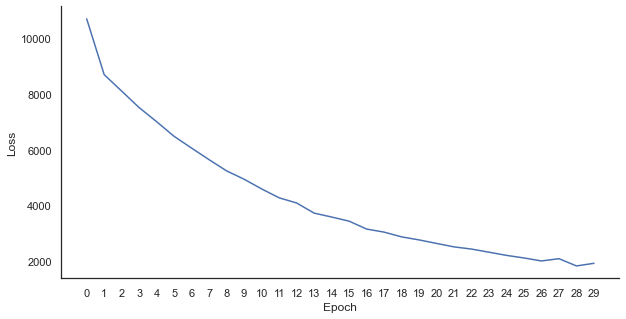

In [22]:
model = ToxicSpansDetection()

model.fit(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    eval_every=1, epochs=params["num_train_epochs"],
    dropout_rate=params["dropout_rate"])

model.plot_losses()

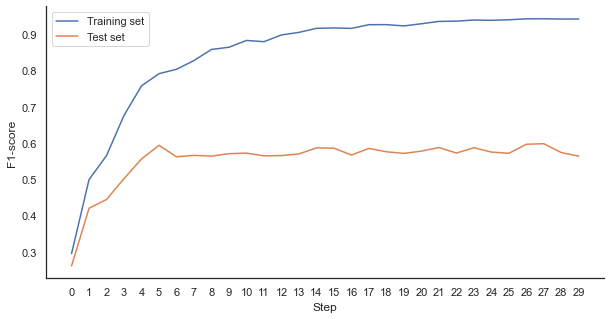

In [30]:
model.plot_scores()

## Evaluation

In [25]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

print("### Training set ###")
print(f"Avg. precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Avg. recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"Avg. F1: {f1_score(y_train, y_train_pred):.4f}")
print()
print("### Test set ###")
print(f"Avg. precision: {precision_score(y_test, y_pred):.4f}")
print(f"Avg. recall: {recall_score(y_test, y_pred):.4f}")
print(f"Avg. F1: {f1_score(y_test, y_pred):.4f}")

### Training set ###
Avg. precision: 0.9526
Avg. recall: 0.9311
Avg. F1: 0.9417

### Test set ###
Avg. precision: 0.6219
Avg. recall: 0.5162
Avg. F1: 0.5642


In [32]:
counter = 0
for pred in y_pred:
    if pred != []:
        counter += 1

print(f"Number of toxic spans predicted: {counter} ({counter / len(y_pred) * 100:.2f}%)")

Number of toxic spans predicted: 1069 (81.48%)


## Test predictions

In [33]:
for i in range(10):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        displacy.render(model._model(X_test[i]), style="ent")